In [96]:
# Cell 1: Imports
import sys
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset


In [97]:
# Cell 2: Generate synthetic time series data
np.random.seed(42)
time = np.arange(0, 1000)
series = np.sin(0.02 * time) + np.random.normal(0, 0.2, size=len(time))

scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series.reshape(-1, 1)).flatten()

def create_dataset(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

seq_length = 500
X, y = create_dataset(series_scaled, seq_length)

X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # shape (batch, seq, 1)
y_tensor = torch.tensor(y, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)



In [98]:
# Cell 3: Standard Self-Attention Module
class SelfAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        scores = torch.bmm(Q, K.transpose(1, 2)) / np.sqrt(Q.size(-1))
        weights = self.softmax(scores)
        return torch.bmm(weights, V)


In [99]:
# Cell 4: FM-Inspired Attention Module
class FMAttention(nn.Module):
    def __init__(self, d_model, h):
        super().__init__()
        self.h = h
        self.dh = d_model // h
        self.L = nn.Linear(d_model, d_model)
        self.U = nn.Linear(self.dh, 1)  # <-- FIXED

    def forward(self, x):
        B, N, D = x.shape
        y = self.L(x)  # B x N x D
        y = y.view(B, N, self.h, self.dh)  # B x N x h x dh
        y = y.permute(0, 2, 1, 3).contiguous().view(B * self.h, N, self.dh)  # (B*h) x N x dh
        scores = self.U(y).squeeze(-1)  # (B*h) x N
        weights = torch.softmax(scores, dim=-1).view(B, self.h, N)
        weights = weights.mean(dim=1).unsqueeze(1)  # B x 1 x N
        output = torch.bmm(weights, x).squeeze(1)  # B x D
        return output.unsqueeze(1).repeat(1, N, 1)  # B x N x D


In [100]:
# Cell 5: Transformer-like model
class TimeSeriesTransformer(nn.Module):
    def __init__(self, attention_module, d_model=16):
        super().__init__()
        self.input_proj = nn.Linear(1, d_model)
        self.attention = attention_module(d_model)
        self.output = nn.Sequential(
            nn.Linear(d_model, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.input_proj(x)
        x = self.attention(x)
        return self.output(x[:, -1])


In [101]:
# Cell 6: Training Function
def train_model(model, loader, epochs=20, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        for xb, yb in loader:
            pred = model(xb).squeeze()
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    return model


In [104]:
# Cell 7: Train both models
model_sa = TimeSeriesTransformer(SelfAttention)
model_fm = TimeSeriesTransformer(lambda d: FMAttention(d, h=4))

print("Training Self-Attention Model:")
model_sa = train_model(model_sa, loader)

print("\nTraining FM-Attention Model:")
model_fm = train_model(model_fm, loader)


Training Self-Attention Model:
Epoch 1, Loss: 0.1292
Epoch 2, Loss: 0.0707
Epoch 3, Loss: 0.0744
Epoch 4, Loss: 0.0649
Epoch 5, Loss: 0.0618
Epoch 6, Loss: 0.0605
Epoch 7, Loss: 0.0564
Epoch 8, Loss: 0.0505
Epoch 9, Loss: 0.0713
Epoch 10, Loss: 0.0652
Epoch 11, Loss: 0.0539
Epoch 12, Loss: 0.0579
Epoch 13, Loss: 0.0646
Epoch 14, Loss: 0.0502
Epoch 15, Loss: 0.0566
Epoch 16, Loss: 0.0501
Epoch 17, Loss: 0.0552
Epoch 18, Loss: 0.0424
Epoch 19, Loss: 0.0245
Epoch 20, Loss: 0.0184

Training FM-Attention Model:
Epoch 1, Loss: 0.5142
Epoch 2, Loss: 0.3713
Epoch 3, Loss: 0.2030
Epoch 4, Loss: 0.1069
Epoch 5, Loss: 0.0693
Epoch 6, Loss: 0.0618
Epoch 7, Loss: 0.0657
Epoch 8, Loss: 0.0708
Epoch 9, Loss: 0.0621
Epoch 10, Loss: 0.0550
Epoch 11, Loss: 0.0610
Epoch 12, Loss: 0.0524
Epoch 13, Loss: 0.0606
Epoch 14, Loss: 0.0540
Epoch 15, Loss: 0.0645
Epoch 16, Loss: 0.0644
Epoch 17, Loss: 0.0571
Epoch 18, Loss: 0.0660
Epoch 19, Loss: 0.0611
Epoch 20, Loss: 0.0609


Self-Attention:    MSE = 0.1745, Total Time = 0.0857s, Avg Time = 0.43 ms/sample
FM-Attention:      MSE = 0.5480, Total Time = 0.0263s, Avg Time = 0.13 ms/sample


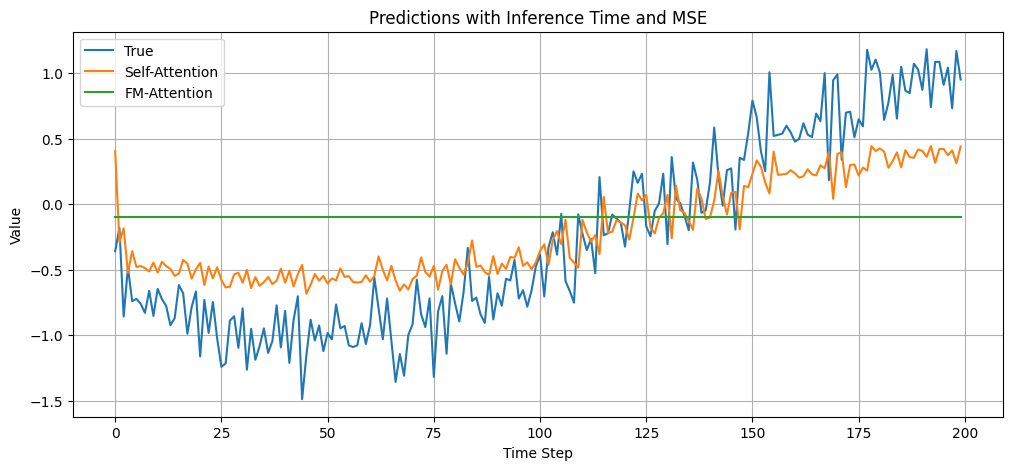

In [105]:
from sklearn.metrics import mean_squared_error
import time

# Ensure models are in eval mode
model_sa.eval()
model_fm.eval()

def predict(model, x):
    with torch.no_grad():
        return model(torch.tensor(x, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)).item()

# Start with the last known sequence
test_input = series_scaled[-seq_length:].copy()
true_vals, sa_preds, fm_preds = [], [], []

# Measure inference time for Self-Attention
start_time_sa = time.time()
for i in range(200):
    sa_pred_scaled = predict(model_sa, test_input)
    sa_pred = scaler.inverse_transform([[sa_pred_scaled]])[0][0]
    true_val_scaled = series_scaled[len(true_vals) + seq_length]
    true_val = scaler.inverse_transform([[true_val_scaled]])[0][0]

    sa_preds.append(sa_pred)
    true_vals.append(true_val)

    test_input = np.roll(test_input, -1)
    test_input[-1] = true_val_scaled
end_time_sa = time.time()

# Reset test input
test_input = series_scaled[-seq_length:].copy()
# Measure inference time for FM-Attention
start_time_fm = time.time()
for i in range(200):
    fm_pred_scaled = predict(model_fm, test_input)
    fm_pred = scaler.inverse_transform([[fm_pred_scaled]])[0][0]
    true_val_scaled = series_scaled[len(fm_preds) + seq_length]
    test_input = np.roll(test_input, -1)
    test_input[-1] = true_val_scaled
    fm_preds.append(fm_pred)
end_time_fm = time.time()

# Metrics
mse_sa = mean_squared_error(true_vals, sa_preds)
mse_fm = mean_squared_error(true_vals, fm_preds)

total_time_sa = end_time_sa - start_time_sa
total_time_fm = end_time_fm - start_time_fm
avg_time_sa = total_time_sa / len(sa_preds)
avg_time_fm = total_time_fm / len(fm_preds)

# Output results
print(f"Self-Attention:    MSE = {mse_sa:.4f}, Total Time = {total_time_sa:.4f}s, Avg Time = {avg_time_sa*1e3:.2f} ms/sample")
print(f"FM-Attention:      MSE = {mse_fm:.4f}, Total Time = {total_time_fm:.4f}s, Avg Time = {avg_time_fm*1e3:.2f} ms/sample")

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(true_vals, label="True")
plt.plot(sa_preds, label="Self-Attention")
plt.plot(fm_preds, label="FM-Attention")
plt.legend()
plt.title("Predictions with Inference Time and MSE")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.show()



In [95]:
from sklearn.metrics import mean_squared_error
import time

runs = 100
seq_length = 500
num_steps = 200

# Store metrics
mse_sa_all, mse_fm_all = [], []
time_sa_all, time_fm_all = [], []

def predict(model, x):
    with torch.no_grad():
        return model(torch.tensor(x, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)).item()

for run in range(runs):
    # --- Self-Attention ---
    test_input = series_scaled[-seq_length:].copy()
    true_vals, sa_preds = [], []
    start_time_sa = time.time()
    for i in range(num_steps):
        sa_pred_scaled = predict(model_sa, test_input)
        sa_pred = scaler.inverse_transform([[sa_pred_scaled]])[0][0]
        true_val_scaled = series_scaled[len(true_vals) + seq_length]
        true_val = scaler.inverse_transform([[true_val_scaled]])[0][0]

        sa_preds.append(sa_pred)
        true_vals.append(true_val)

        test_input = np.roll(test_input, -1)
        test_input[-1] = true_val_scaled
    end_time_sa = time.time()

    mse_sa_all.append(mean_squared_error(true_vals, sa_preds))
    time_sa_all.append(end_time_sa - start_time_sa)

    # --- FM-Attention ---
    test_input = series_scaled[-seq_length:].copy()
    fm_preds = []
    start_time_fm = time.time()
    for i in range(num_steps):
        fm_pred_scaled = predict(model_fm, test_input)
        fm_pred = scaler.inverse_transform([[fm_pred_scaled]])[0][0]
        true_val_scaled = series_scaled[len(fm_preds) + seq_length]
        test_input = np.roll(test_input, -1)
        test_input[-1] = true_val_scaled
        fm_preds.append(fm_pred)
    end_time_fm = time.time()

    mse_fm_all.append(mean_squared_error(true_vals, fm_preds))
    time_fm_all.append(end_time_fm - start_time_fm)

# Averages
avg_mse_sa = np.mean(mse_sa_all)
avg_mse_fm = np.mean(mse_fm_all)
avg_time_sa = np.mean(time_sa_all)
avg_time_fm = np.mean(time_fm_all)

print("=== Average Over 100 Runs ===")
print(f"Self-Attention -> MSE: {avg_mse_sa:.4f}, Total Time: {avg_time_sa:.4f}s, Avg/sample: {avg_time_sa / num_steps * 1000:.2f} ms")
print(f"FM-Attention   -> MSE: {avg_mse_fm:.4f}, Total Time: {avg_time_fm:.4f}s, Avg/sample: {avg_time_fm / num_steps * 1000:.2f} ms")


=== Average Over 100 Runs ===
Self-Attention -> MSE: 0.1765, Total Time: 0.0309s, Avg/sample: 0.15 ms
FM-Attention   -> MSE: 0.3487, Total Time: 0.0215s, Avg/sample: 0.11 ms
